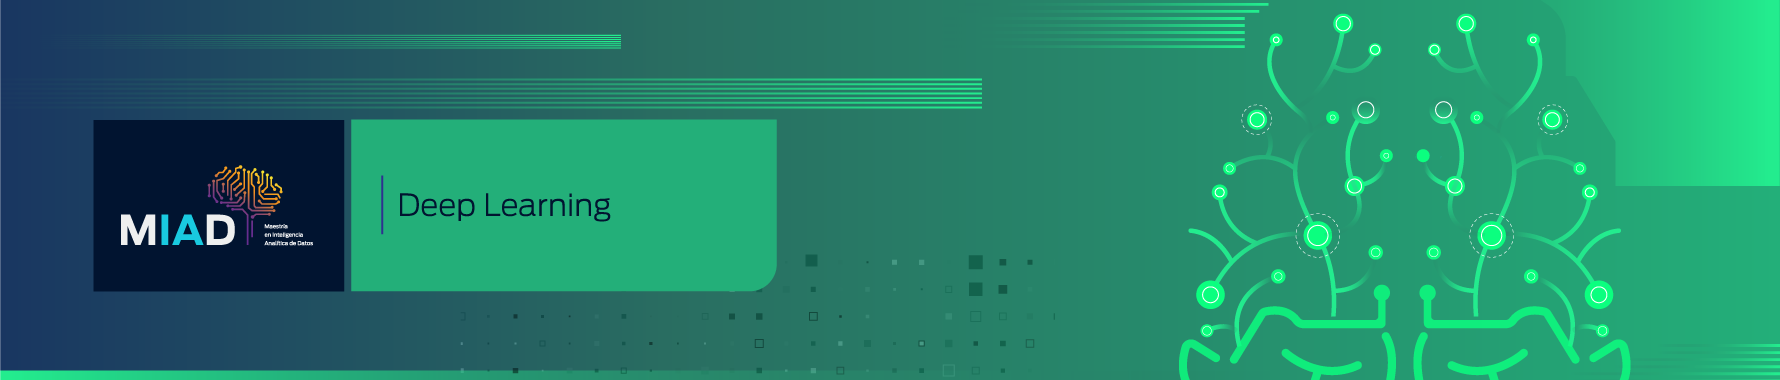

# Deep learning - Semana 3: Estrategias de implementación
# Algortimos mejorados: _RMSProp_ y Adam

## Propósito
En esta actividad se implementan y comparan las diferentes estrategias de _RMSProp_ y _Adaptive Moment Estimation_ (ADAM). 

## Instrucciones generales

Esta es una actividad individual, la cual puede descargar eligiendo la opción ‘Download as’ del menú ‘File’ y descargar el archivo en formato notebook (.ipynb). También puede resolverla directamente sobre la herramienta del curso.

En el laboratorio hay dos ejercicios: 
1. Implementación manual de algortimos _RMSProp_ y ADAM en estimación de red neuronal de una capa.
2. Implementación de de algortimos _RMSProp_ y ADAM  en _Keras_ y comparación de valores de hiperparámetros.

## 1. Implementación manual de momento en estimación de red neuronal de una capa

En este caso se trabajará con la implementación "manual" del algoritmo de gradiente descendiente para una red neuronal de una capa que desarrollamos en un laboratorio anterior. 

Los datos a usar fueron extraídos de imágenes que fueron tomadas de billetes. Para su digitalización, se utilizó una cámara industrial usada para la impresión. Luego, las imágenes de 400x400 pixeles se sometieron a un procedimiento de transformación de onda (Wavelet transformation) con la intención de extraer los features para la predicción. En este contexto, la variable de respuesta corresponde a si un billete es auténtico (y=1) o si no lo es (y=0) y las variables predictivas son las siguientes:

1. *variance* *of* *Wavelet* *Transformed* *image* *(continuous)*
2. *skewness* *of* *Wavelet* *Transformed* *image* *(continuous)*
3. *curtosis* *of* *Wavelet* *Transformed* *image* *(continuous)*
4. *entropy* *of* *image* *(continuous)*

Primero corremos las funciones para definir las estructuras, la inicialización de parámetros, la función de activación y el mecanismo de _forward propagation_:


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

data = np.genfromtxt('data_banknote_authentication.txt', delimiter = ',')
X = data[:,:4]
y = data[:, 4]
y=y.reshape(y.shape[0], 1)

def estructuras(X, Y):
    input_unit = X.shape[1] # Dimensión de entrada
    hidden_unit = 58 # Unidades de capa oculta
    output_unit = Y.shape[1] # Dimensión de variable de salida
    return (input_unit, hidden_unit, output_unit)


def inicializacion(input_unit, hidden_unit, output_unit):
    np.random.seed(3) 
    W1 = np.random.randn(input_unit, hidden_unit)*0.01
    b1 = np.zeros((1, hidden_unit))
    W2 = np.random.randn(hidden_unit, output_unit)*0.01
    b2 = np.zeros((1, output_unit))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


def sigmoid(z):
    return 1/(1+np.exp(-z))

def forward_propagation(X, parameters):
    
    #Se cargan los valores de los parámetros
    
    W1 = parameters['W1'] #Valor de los pesos de la primera capa
    b1 = parameters['b1'] #Valor de los interceptos de la primera capa
    W2 = parameters['W2'] #Valor de los pesos de la salida
    b2 = parameters['b2'] #Valor de los interceptos de la salida
    
    Z1 = np.dot(X, W1) + b1 #Cálculo de la transformación afín de la primera capa
    A1 = sigmoid(Z1) #Evaluación de la función sigmoide de la primera capa
    Z2 = np.dot(A1, W2) + b2 #Cálculo de la transformación afín de la salida
    A2 = sigmoid(Z2) #Evaluación de la función sigmoide de la salida
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, cache

Ahora definimos la función objetivo a minimizar _(cross-entropy)_ y el cálculo de gradientes por _backward propagation_.


In [2]:
def cross_entropy_cost(A2, Y, parameters):
    # Muestras de entrenamiento
    n = Y.shape[0] 
    # Calcular cross entropy
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / n
    cost = float(np.squeeze(cost))    
    
    return cost


def backward_propagation(parameters, cache, X, Y):
    #Muestras de entrenamiento
    n = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    dZ2 = (1/n) *(A2-Y)
    dW2 = np.dot(A1.T,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.multiply(np.dot(dZ2,W2.T), A1 - np.power(A1, 2))
    dW1 = np.dot(X.T,dZ1) 
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    return grads

### Implementacion _RMSProp_ y ADAM:
En las funciones de "gradient descent" y "neural network model" se implementa la estrategia de momento usando el valor de $s(\theta)$ como la función suavizada de los gradientes $d(\theta)$ para el parámetro $\theta$ que puede representar una matriz $W$ o un vector de interceptos $b$. Así mismo, se usa el valor $r(\theta)$ (escrito como "sW1_2", etc), para representar la serie suavizada de los gradientes al cuadrado $d(\theta)^2$.

En la función "neural network model" se actualizan los valores de $s(\theta)$ y $r(\theta)$, y se parametriza cuál de los dos algoritmos se usa: _RMSProp_ o ADAM. Se usan los hiper-parámetros $\beta_M$ (para momento en ADAM), $\beta_R$ (para _RMSProp_ ), $\epsilon$ y la tasa de aprendizaje. Tenga en cuenta que se dejaron algunos valores por defecto.

In [3]:
def gradient_descent(parameters, smooth, learning_rate = 0.01):
    
    #Se capturan los valores actuales para los parámetros de la red neuronal
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #Se capturan los valores de los gradientes suavizados
    sW1 = smooth['sW1']
    sb1 = smooth['sb1']
    sW2 = smooth['sW2']
    sb2 = smooth['sb2']
    
    #Se actualizan los valores de los parámetros siguiendo la dirección contraria del gradiente
    W1 = W1 - learning_rate * sW1
    b1 = b1 - learning_rate * sb1
    W2 = W2 - learning_rate * sW2
    b2 = b2 - learning_rate * sb2
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2}
    
    return parameters


def neural_network_model(X, Y, hidden_unit, algorithm='adam', beta_m=0.9, beta_r=0.95, epsilon=0.0001, learning_rate=0.01,  num_iterations = 10000):
    np.random.seed(3)
        
    input_unit = estructuras(X, Y)[0]
    output_unit = estructuras(X, Y)[2]
    
    #Se inicializan los parámetros de manera aleatoria
    parameters = inicializacion(input_unit, hidden_unit, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    costs=[]
    
    #inicializadión de términos suavización exponencial
    sW1 = 0
    sb1 = 0
    sW2 = 0
    sb2 = 0

    sW1_2 = 0
    sb1_2 = 0
    sW2_2 = 0
    sb2_2 = 0

    for i in range(0, num_iterations):
                
        A2, cache = forward_propagation(X, parameters) #Se calcula la salida de la red para los datos utilizados y los valores de los parámetros para cada iteración
        
        cost = cross_entropy_cost(A2, Y, parameters) #Se calcula la función de costos
        
        costs.append(cost) #Se guardan el valor de la función de costos para cada iteración
        
        grads = backward_propagation(parameters, cache, X, Y) #Se calcula el gradiente de la función de costos utilizando el método de backpropagation para cada iteración
    
        dW1 = grads['dW1']
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']
        
        sW1 = sW1*beta_m + (1-beta_m)*dW1
        sb1 = sb1*beta_m + (1-beta_m)*db1
        sW2 = sW2*beta_m + (1-beta_m)*dW2
        sb2 = sb2*beta_m + (1-beta_m)*db2

        sW1_2 = sW1_2*beta_r + (1-beta_r)*dW1**2
        sb1_2 = sb1_2*beta_r + (1-beta_r)*db1**2
        sW2_2 = sW2_2*beta_r + (1-beta_r)*dW2**2
        sb2_2 = sb2_2*beta_r + (1-beta_r)*db2**2
        
        smooth_1={"sW1": sW1, "sb1": sb1, "sW2": sW2,"sb2": sb2}
        smooth_2={"sW1_2": sW1_2, "sb1_2": sb1_2, "sW2_2": sW2_2,"sb2_2": sb2_2}
        
        if (algorithm=="rmsprop"):
            smooth = {"sW1": dW1/np.sqrt(sW1_2+epsilon), "sb1": db1/np.sqrt(sb1_2+epsilon), "sW2": dW2/np.sqrt(sW2_2+epsilon),"sb2": db2/np.sqrt(sb2_2+epsilon)}
            parameters = gradient_descent(parameters, smooth,learning_rate=learning_rate) #Se actualiza el valor de los parámetros
            
        if (algorithm=="adam"):
            smooth = {"sW1": sW1/np.sqrt(sW1_2+epsilon), "sb1": sb1/np.sqrt(sb1_2+epsilon), "sW2": sW2/np.sqrt(sW2_2+epsilon),"sb2": sb2/np.sqrt(sb2_2+epsilon)}
            parameters = gradient_descent(parameters, smooth,learning_rate=learning_rate) #Se actualiza el valor de los parámetros
        
        if i % 10 == 0:
            print ("Costo en la iteracion  %i: %f" %(i, cost))
    return parameters, costs

### Implementación _RMSProp_

Empezamos con el algortimo _RMSProp_, con $\beta_R=0.95$, $\epsilon=0.0001$ y tasa de aprendizaje de 0.01. Se usan además 20 nodos ocultos en la capa intermedia (este proceso puede tomar unos minutos si se ejecuta en la plataforma de Coursera).

In [4]:
start = time.time()
parameters, costs = neural_network_model(X, y, 20, algorithm='rmsprop', beta_r=0.95, epsilon=0.0001, learning_rate=0.01, num_iterations=15000)
end = time.time()
print("Tiempo de ejecución: " +str(end - start))

Costo en la iteracion  0: 0.691762
Costo en la iteracion  10: 0.611590
Costo en la iteracion  20: 0.418744
Costo en la iteracion  30: 0.269401
Costo en la iteracion  40: 0.185066
Costo en la iteracion  50: 0.135519
Costo en la iteracion  60: 0.104605
Costo en la iteracion  70: 0.084207
Costo en la iteracion  80: 0.070099
Costo en la iteracion  90: 0.059985
Costo en la iteracion  100: 0.052532
Costo en la iteracion  110: 0.046917
Costo en la iteracion  120: 0.042611
Costo en la iteracion  130: 0.039258
Costo en la iteracion  140: 0.036609
Costo en la iteracion  150: 0.034489
Costo en la iteracion  160: 0.032772
Costo en la iteracion  170: 0.031361
Costo en la iteracion  180: 0.030189
Costo en la iteracion  190: 0.029202
Costo en la iteracion  200: 0.028361
Costo en la iteracion  210: 0.027637
Costo en la iteracion  220: 0.027007
Costo en la iteracion  230: 0.026453
Costo en la iteracion  240: 0.025963
Costo en la iteracion  250: 0.025524
Costo en la iteracion  260: 0.025130
Costo en la 

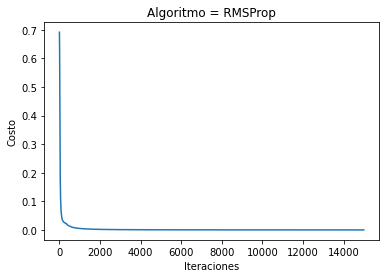

In [5]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Algoritmo = RMSProp" )
plt.show()

### Implementación ADAM

Ahora miremos el algortimo ADAM, con $\beta_M=0.9$, $\beta_R=0.95$, $\epsilon=0.0001$ y tasa de aprendizaje de 0.01. Se usan además 20 nodos ocultos en la capa intermedia (este proceso puede tomar unos minutos si se ejecuta en la plataforma de Coursera).

In [6]:
start = time.time()
parameters, costs = neural_network_model(X, y, 20, algorithm='adam', beta_m=0.9, beta_r=0.95, epsilon=0.0001, learning_rate=0.01, num_iterations=15000)
end = time.time()
print("Tiempo de ejecución: " +str(end - start))

Costo en la iteracion  0: 0.691762
Costo en la iteracion  10: 0.680851
Costo en la iteracion  20: 0.643629
Costo en la iteracion  30: 0.565325
Costo en la iteracion  40: 0.453720
Costo en la iteracion  50: 0.329761
Costo en la iteracion  60: 0.232887
Costo en la iteracion  70: 0.165232
Costo en la iteracion  80: 0.121252
Costo en la iteracion  90: 0.092713
Costo en la iteracion  100: 0.073948
Costo en la iteracion  110: 0.061242
Costo en la iteracion  120: 0.052324
Costo en la iteracion  130: 0.045859
Costo en la iteracion  140: 0.041038
Costo en la iteracion  150: 0.037348
Costo en la iteracion  160: 0.034449
Costo en la iteracion  170: 0.032120
Costo en la iteracion  180: 0.030211
Costo en la iteracion  190: 0.028620
Costo en la iteracion  200: 0.027275
Costo en la iteracion  210: 0.026122
Costo en la iteracion  220: 0.025124
Costo en la iteracion  230: 0.024247
Costo en la iteracion  240: 0.023470
Costo en la iteracion  250: 0.022774
Costo en la iteracion  260: 0.022144
Costo en la 

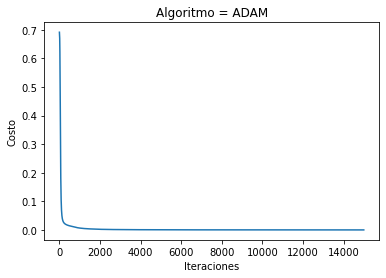

In [7]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Algoritmo = ADAM" )
plt.show()

Note que los dos algoritmos se corrieron con la misma tasa de aprendizaje ($\alpha$). Sin embargo, dada la forma en que se están actualizando los pasos en las iteraciones, la tasa que funciona en ADAM no necesariamente es la misma que funciona mejor en _RMSProp_. De esta forma, es importante calibrar $\alpha$ de acuerdo al algoritmo que se esté usando.


#### Ejercicio no evaluable:
Intente calibrar los hiper-parámetros de los dos algoritmos y compare los resultados.

## 2. Implementación en Keras de _RMSProp_ y ADAM

En _Keras_ se pueden cambiar los algoritmos de estimación  usando _optimizer_, que se pueden usar cuando en un modelo se ejecuta "compile()" o "fit()".  Para revisar los optimizadores disponibles, puede consultar la información contenida en: https://keras.io/api/optimizers/.

Cada optimizador tiene sus argumentos, que corresponden a los hiper-parámetros del mismo. Por ejemplo, en el optimizador "RMSprop", el parámetro que conocemos como $\beta_R$, se llama "rho". Mientras que en el optimizador "ADAM". los parámetros $\beta_M$ y $\beta_R$ se llaman respectivamente "beta_1" y "beta_2".

En este caso, uasaremos la base de datos del _National Institute of Diabetes and Digestive and Kidney Diseases_. La variable de interés 'Clase' es una variable binaria toma el valor de 1 en caso de que el paciente tenga diabetes o de 0 en caso contrario. Estos datos ya habían sido usados en un ejercicio anterior y, en este caso, exploraremos la sensibilidad de la estimación de la red en términos del _momentum_.


In [8]:
import pandas as pd
from numpy import loadtxt
from matplotlib import pyplot  as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from sklearn import metrics

from keras.optimizers import SGD  #para cambiar el parámetro "momentum"

dataset = pd.read_csv('test2.csv', sep=",")
dataset=dataset.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(dataset[:,0:8], dataset[:,8], test_size=0.20)

Using TensorFlow backend.


Recuerde que la tasa de aprendizaje $(\alpha)$ que funciona para un valor de momentum, no es necesariamente igual a la que funciona para otro valor. En el siguiente código, se implementa _RMSProp_ con los parámetros indicados en el código, los cuales puede modificar para lograr mejores resultados:

In [9]:
n=X_train.shape[0]

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

beta_r=0.95

rmsprop=RMSprop(learning_rate=0.01, rho=beta_r, epsilon=0.00001)

model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

start = time.time()

#history=model.fit(X_train, y_train, epochs=250, batch_size=128)

history=model.fit(X_train, y_train, epochs=250, batch_size=32)

end = time.time()

Epoch 1/250
614/614 [==============================] - 0s 292us/step - loss: 5.2467 - accuracy: 0.5309
Epoch 2/250
614/614 [==============================] - 0s 29us/step - loss: 2.6059 - accuracy: 0.5603
Epoch 3/250
614/614 [==============================] - 0s 30us/step - loss: 1.7992 - accuracy: 0.5603
Epoch 4/250
614/614 [==============================] - 0s 43us/step - loss: 1.3051 - accuracy: 0.5928
Epoch 5/250
614/614 [==============================] - 0s 31us/step - loss: 1.2989 - accuracy: 0.6010
Epoch 6/250
614/614 [==============================] - 0s 29us/step - loss: 1.3549 - accuracy: 0.6221
Epoch 7/250
614/614 [==============================] - 0s 27us/step - loss: 0.9453 - accuracy: 0.6042
Epoch 8/250
614/614 [==============================] - 0s 27us/step - loss: 0.9992 - accuracy: 0.6189
Epoch 9/250
614/614 [==============================] - 0s 35us/step - loss: 0.8397 - accuracy: 0.6336
Epoch 10/250
614/614 [==============================] - 0s 26us/step - loss: 0.66

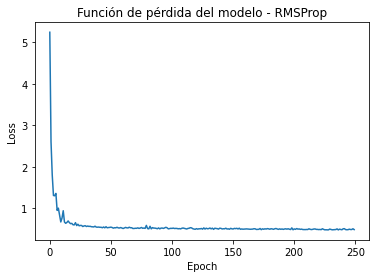

Tiempo de ejecución: 4.743549346923828


In [10]:
plt.plot(history.history['loss'])
plt.title('Función de pérdida del modelo - RMSProp')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

print("Tiempo de ejecución: " +str(end - start))

Ahora implementamos el algoritmo ADAM:

In [11]:
n=X_train.shape[0]

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

beta_m=0.9
beta_r=0.95

opt=Adam(learning_rate=0.01, beta_1=beta_m, beta_2=beta_r, epsilon=0.00001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.time()

#history=model.fit(X_train, y_train, epochs=250, batch_size=128)

history=model.fit(X_train, y_train, epochs=250, batch_size=32)

end = time.time()

Epoch 1/250
614/614 [==============================] - 0s 222us/step - loss: 4.6835 - accuracy: 0.5733
Epoch 2/250
614/614 [==============================] - 0s 34us/step - loss: 0.7866 - accuracy: 0.5489
Epoch 3/250
614/614 [==============================] - 0s 34us/step - loss: 0.6625 - accuracy: 0.6482
Epoch 4/250
614/614 [==============================] - 0s 62us/step - loss: 0.6392 - accuracy: 0.6726
Epoch 5/250
614/614 [==============================] - 0s 34us/step - loss: 0.6158 - accuracy: 0.6824
Epoch 6/250
614/614 [==============================] - 0s 29us/step - loss: 0.6186 - accuracy: 0.6792
Epoch 7/250
614/614 [==============================] - 0s 27us/step - loss: 0.6232 - accuracy: 0.6531
Epoch 8/250
614/614 [==============================] - 0s 26us/step - loss: 0.5999 - accuracy: 0.6873
Epoch 9/250
614/614 [==============================] - 0s 45us/step - loss: 0.5994 - accuracy: 0.6987
Epoch 10/250
614/614 [==============================] - 0s 27us/step - loss: 0.57

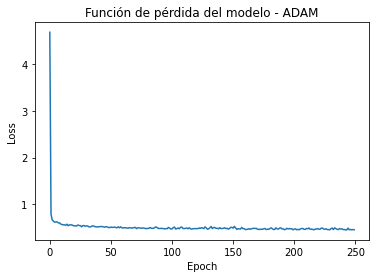

Tiempo de ejecución: 4.89769172668457


In [12]:
plt.plot(history.history['loss'])
plt.title('Función de pérdida del modelo - ADAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

print("Tiempo de ejecución: " +str(end - start))